OWLv2
=====

**Scaling Open-Vocabulary Object Detection**

 * Paper: https://arxiv.org/abs/2306.09683

![OWLv2 Overview - Trainnig Steps](../assets/owlv2_overview.jpg)

**Installation**

```bash
pip install matplotlib
pip install supervision
pip install torch torchvision
pip install transformers
```

In [1]:
from PIL import Image
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
import torch
from transformers import Owlv2Processor, Owlv2ForObjectDetection

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = Owlv2Processor.from_pretrained(
    "google/owlv2-base-patch16-ensemble"
)
model = Owlv2ForObjectDetection.from_pretrained(
    "google/owlv2-base-patch16-ensemble"
)

model.eval().to(device);

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
image_path = "../samples/plants.jpg"
image = Image.open(image_path).convert("RGB")
text_labels = [["a photo of a plant", "a photo of a vase"]]

inputs = processor(text=text_labels, images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs.to(device))

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.tensor([(image.height, image.width)])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.1, text_labels=text_labels
)
# Retrieve predictions for the first image for the corresponding text queries
result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]
for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text_label} with confidence {round(score.item(), 3)} at location {box}")

Detected a photo of a plant with confidence 0.287 at location [433.84, 80.24, 782.08, 567.91]
Detected a photo of a plant with confidence 0.23 at location [131.67, 77.66, 796.18, 1093.71]
Detected a photo of a plant with confidence 0.161 at location [419.01, 81.3, 794.58, 1095.24]
Detected a photo of a plant with confidence 0.47 at location [429.21, 74.49, 785.58, 792.97]
Detected a photo of a plant with confidence 0.336 at location [132.06, 506.97, 455.65, 696.86]
Detected a photo of a vase with confidence 0.161 at location [500.58, 503.25, 780.62, 791.3]
Detected a photo of a plant with confidence 0.365 at location [128.73, 511.09, 451.21, 913.02]
Detected a photo of a vase with confidence 0.166 at location [157.52, 634.0, 392.11, 903.22]
Detected a photo of a vase with confidence 0.215 at location [156.29, 681.66, 385.4, 1094.94]
Detected a photo of a vase with confidence 0.338 at location [464.77, 520.86, 776.94, 1096.92]
Detected a photo of a vase with confidence 0.126 at location

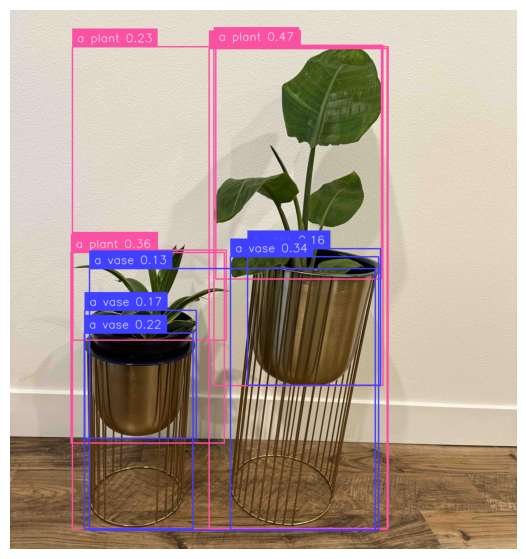

In [9]:
detections = sv.Detections(
    xyxy=boxes.cpu().numpy(),
    confidence=scores.cpu().numpy(),
    class_id=results[0]["labels"].cpu().numpy()
)

box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.8)

annotated_image = box_annotator.annotate(
    scene=np.array(image),
    detections=detections
)
str_labels = [t.replace("a photo of ", "") for t in text_labels]
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=[
        f"{txt} {round(sc.item(), 2)}"
        for txt, sc in zip(str_labels, scores)
    ]
)


fig = plt.figure(figsize=(7, 7), dpi=100)
plt.imshow(annotated_image)
plt.axis("off")
plt.show()